In [1]:
# %pip install -r requirements.txt

Note:<br>
This demo is adapted from the LXMERT Demo present here: https://github.com/huggingface/transformers/tree/main/examples/research_projects/lxmert
<br>and VisualBERT VQA Demo present here: https://github.com/huggingface/transformers/tree/main/examples/research_projects/visual_bert

In [2]:
import PIL.Image
import io
import torch
import numpy as np
import utils

In [3]:
from utils import Config
from IPython.display import Image, display
from processing_image import Preprocess
from visualizing_image import SingleImageViz
from modeling_frcnn import GeneralizedRCNN
from transformers import BertTokenizer, BertTokenizerFast
from transformers import VisualBertModel, VisualBertForPreTraining, VisualBertForQuestionAnswering, VisualBertForRegionToPhraseAlignment, BertTokenizerFast

In [4]:
data_path = 'dataset/Flicker8k_Dataset'

# URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/images/input.jpg"
# URL = "https://farm7.staticflickr.com/6128/5977581130_f62fe66048_z.jpg"
URL = f'{data_path}/124.jpg'
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://dl.fbaipublicfiles.com/pythia/data/answers_vqa.txt"

In [5]:
# load object, attribute, and answer labels
objids = utils.get_data(OBJ_URL)
attrids = utils.get_data(ATTR_URL)
# vqa_answers = utils.get_data(VQA_URL)

In [6]:
# load models and model components
frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")

frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg)

image_preprocess = Preprocess(frcnn_cfg)

bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# bert_tokenizer_fast = BertTokenizerFast.from_pretrained("bert-base-uncased")

# visualbert_vqa = VisualBertForQuestionAnswering.from_pretrained("uclanlp/visualbert-vqa")
# visualbert_model = VisualBertModel.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
# visualbert_rpa = VisualBertForRegionToPhraseAlignment.from_pretrained("uclanlp/visualbert-vqa-coco-pre")
visualbert_pre = VisualBertForPreTraining.from_pretrained("uclanlp/visualbert-vqa-coco-pre")

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /home/dhiya/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


In [7]:
# for visualizing output
def showarray(a, fmt="jpeg"):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

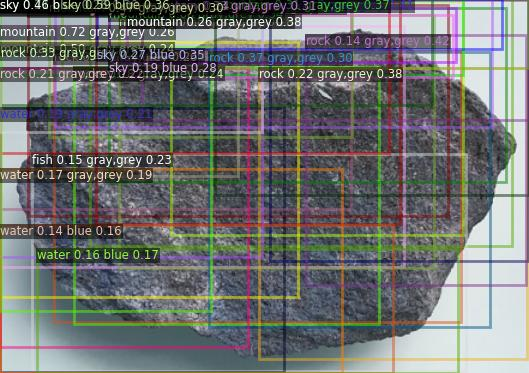

In [8]:
# image viz
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

# run frcnn
images, sizes, scales_yx = image_preprocess(URL)
output_dict = frcnn(
    images,
    sizes,
    scales_yx=scales_yx,
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

# add boxes and labels to the image
frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)

showarray(frcnn_visualizer._get_buffer())

In [9]:
features = output_dict.get("roi_features")

In [10]:
text_caption = [
    "Andesit berwarna coklat dan abu-abu tua yang bertekstur hornblende",
    "Andesit coklat dan abu-abu tua dengan tekstur hornblende",
    "Andesit bertekstur hornblende",
    "Andesit warna coklat abu-abu tua tekstur hornblende",
    "Andesit coklat dan abu tua tekstur hornblende",
]

flat_caption = " ".join(text_caption)
words = flat_caption.split()
formatted_word = " ".join(sorted(set(words), key=words.index))
print (formatted_word)

Andesit berwarna coklat dan abu-abu tua yang bertekstur hornblende dengan tekstur warna abu


In [11]:
inputs = bert_tokenizer(
    formatted_word,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt",
)

inputs.update(
    {
        "visual_embeds": features,
        "visual_attention_mask": torch.ones(features.shape[:-1]),
        "output_attentions": False,
    }
)

max_length = inputs["input_ids"].shape[-1] + features.shape[-2]
labels = bert_tokenizer(
    formatted_word, return_tensors="pt", padding="max_length", max_length=max_length
)["input_ids"]
sentence_image_labels = torch.tensor(1).unsqueeze(0)  # Batch_size

outputs = visualbert_pre(**inputs, labels=labels, sentence_image_labels=sentence_image_labels)

loss = outputs.loss
print(f"loss: {loss}")
prediction_logits = outputs.prediction_logits.argmax(-1)
print(f"prediction_logits: {prediction_logits}\n")

for i in range(len(text_caption)): print(f"{i+1}. {text_caption[i]}")

# get prediction
print("\nPrediction:", bert_tokenizer.decode(prediction_logits[0]))

loss: 10.175864219665527
prediction_logits: tensor([[ 1012, 10930,  4183,  2022,  2099,  9028,  2532,  2522, 26086,  2102,
          4907,  8273,  1011,  8273, 10722,  2050,  8675,  2016,  5937,  1012,
          2524,  2723,  2723,  2723,  2317,  2723,  2723,  2723,  2723,  2598,
          2317,  2723,  2317,  2524,  2598,  2317,  2524,  2598,  2015,  2317,
          2524,  2524,  2317,  2723,  2723,  2078,  2723,  2723,  2723,  2723,
          2829,  2723,  2006,  2006,  2829,  2723]])

1. Andesit berwarna coklat dan abu-abu tua yang bertekstur hornblende
2. Andesit coklat dan abu-abu tua dengan tekstur hornblende
3. Andesit bertekstur hornblende
4. Andesit warna coklat abu-abu tua tekstur hornblende
5. Andesit coklat dan abu tua tekstur hornblende

Prediction: . yoit berwarna coklat dan abu - abu tua yang sheek. hard floor floor floor white floor floor floor floor ground white floor white hard ground white hard grounds white hard hard white floor floorn floor floor floor floor brown 

### --- All cells below for exploration ---

In [12]:
%%script false --no-raise-error

test_questions_for_url2 = [
    "Where is the cat?",
    "What is near the disk?",
    "What is the color of the table?",
    "What is the color of the cat?",
    "What is the shape of the monitor?",
]

In [13]:
%%script false --no-raise-error

for test_question in test_questions_for_url2:
    test_question = [test_question]

    inputs = bert_tokenizer(
        test_question,
        padding="max_length",
        max_length=5,
        truncation=True,
        return_token_type_ids=True,
        return_attention_mask=True,
        add_special_tokens=True,
        return_tensors="pt",
    )

    output_vqa = visualbert_vqa(
        input_ids=inputs.input_ids,
        attention_mask=inputs.attention_mask,
        visual_embeds=features,
        visual_attention_mask=torch.ones(features.shape[:-1]),
        token_type_ids=inputs.token_type_ids,
        output_attentions=False,
    )

    # get prediction
    pred_vqa = output_vqa["logits"].argmax(-1)
    print(pred_vqa)
    
    preds = pred_vqa
    print(bert_tokenizer.decode(pred_vqa))

    print("Question:", test_question)
    print("prediction from VisualBert VQA:", vqa_answers[pred_vqa])

In [14]:
%%script false --no-raise-error

test_question = formatted_word

inputs = bert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt",
)

output_rpa = visualbert_rpa(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_embeds=features,
    visual_attention_mask=torch.ones(features.shape[:-1]),
    region_to_phrase_position=torch.ones((1,inputs["input_ids"].shape[-1]+features.shape[-2])).type(torch.int64),
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)

# get prediction
pred_rpa = output_rpa["logits"].argmax(-1)
print(pred_rpa)

print(bert_tokenizer.decode(inputs["input_ids"][0]))
print(bert_tokenizer.decode(pred_rpa[0]))

In [15]:
%%script false --no-raise-error

test_question = [formatted_word]

inputs = bert_tokenizer(
    test_question,
    padding="max_length",
    max_length=20,
    truncation=True,
    return_token_type_ids=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt",
)

output_model = visualbert_model(
    input_ids=inputs.input_ids,
    attention_mask=inputs.attention_mask,
    visual_embeds=features,
    visual_attention_mask=torch.ones(features.shape[:-1]),
    token_type_ids=inputs.token_type_ids,
    output_attentions=False,
)
print(output_model)

# get prediction
pred_model = output_model["last_hidden_state"].argmax(-1)
print(pred_model)
print("prediction from VisualBert VQA:", vqa_answers[26])

print(bert_tokenizer.decode(inputs["input_ids"][0]))
print(bert_tokenizer.decode(pred_model[0]))